In [165]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
#decision tree
raw_data = pd.read_csv('/Users/Jade/Google Drive/Introduction to Data Science/project/merge_sample.csv')

split = 0.8
raw_data.shape
rand = np.random.rand(raw_data.shape[0])
rand_filt = (rand < split)

train_df = raw_data[rand_filt]
test_df = raw_data[(rand_filt == False)]

X_train = train_df.drop('act_outcome',1)
Y_train = train_df.act_outcome
X_test = test_df.drop('act_outcome',1)
Y_test = test_df.act_outcome


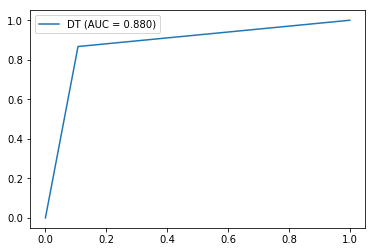

0.88137122237257559

In [111]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
dt = DecisionTreeClassifier(criterion='entropy')
dt = dt.fit(X_train,Y_train)
train_ac = dt.score(X_train,Y_train)
test_ac = dt.score(X_test,Y_test)
dt_preds = dt.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(Y_test, dt_preds)
roc_auc = auc(fpr, tpr)
if roc_auc < 0.5:
    fpr, tpr, thresholds = roc_curve(Y_test, -1 * dt_preds)
    roc_auc = auc(fpr, tpr)   
plt.plot(fpr, tpr, label = 'DT (AUC = %0.3f)' % roc_auc)
plt.legend()
plt.show()
dt.score(X_test,Y_test)

In [112]:
#feature importance 
feature_mi = dt.feature_importances_
feature_mi_dict = dict(zip(X_train.columns.values, feature_mi))

In [113]:
def plotUnivariateROC(preds, truth, label_string):
    fpr, tpr, thresholds = roc_curve(truth, preds)
    roc_auc = auc(fpr, tpr)
    if roc_auc < 0.5:
        fpr, tpr, thresholds = roc_curve(truth, -1 * preds)
        roc_auc = auc(fpr, tpr)
    #chooses a random color for plotting
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    #create a plot and set some options
    plt.plot(fpr, tpr, color = c, label = label_string + ' (AUC = %0.3f)' % roc_auc) 
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")    
    return roc_auc

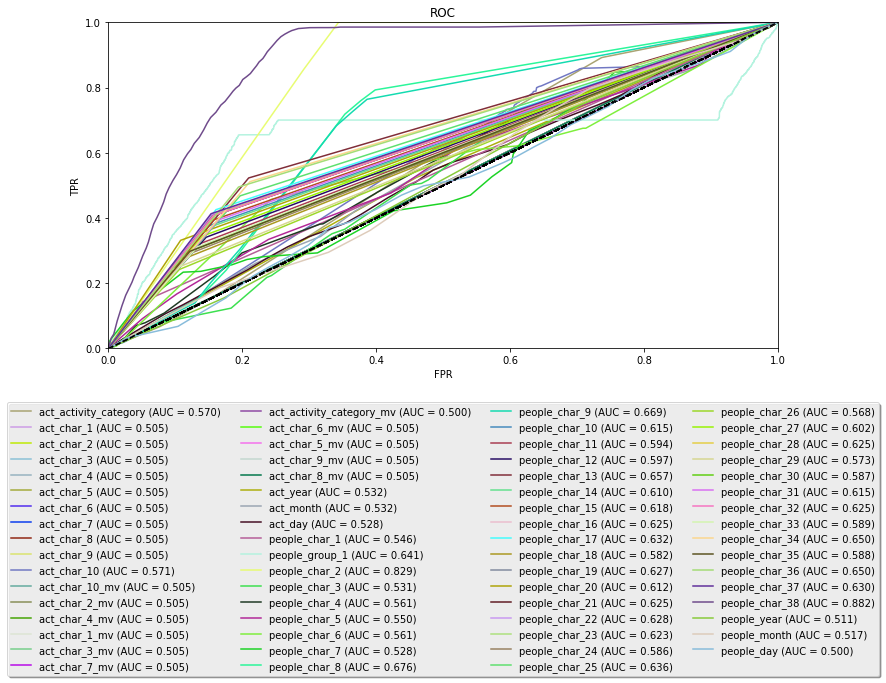

In [114]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

feature_auc_dict = {}
for col in X_train.columns:    
    feature_auc_dict[col] = plotUnivariateROC(raw_data[col], raw_data.act_outcome, col)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

In [115]:
df_auc = pd.DataFrame(pd.Series(feature_auc_dict), columns = ['auc'])
df_mi = pd.DataFrame(pd.Series(feature_mi_dict), columns = ['mi'])
feat_imp_df = df_auc.merge(df_mi, left_index = True, right_index = True)

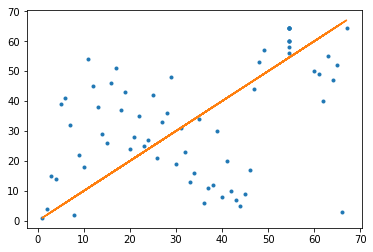

In [116]:
#Now create a df that holds the ranks of auc and mi 
feat_ranks = feat_imp_df.rank(axis = 0, ascending = False)
#Plot the two ranks
plt.plot(feat_ranks.auc, feat_ranks.mi, '.')
#Plot a y=x reference line
plt.plot(feat_ranks.auc, feat_ranks.auc,)

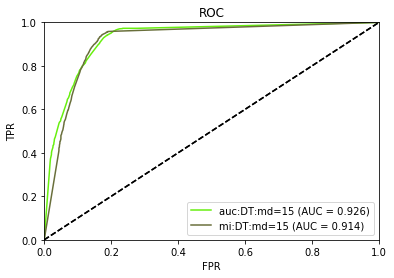

In [148]:
#Now create lists of top 5 features for both auc and mi
top_auc = list(feat_ranks[(feat_ranks.auc <= 32)].index.values)
top_mi = list(feat_ranks[(feat_ranks.mi <= 32)].index.values)
# top 31 features and auc is better 

fsets = [top_auc, top_mi]
fset_descr = ['auc', 'mi']

mxdepths = [15]

for i, fset in enumerate(fsets):
    descr = fset_descr[i]
    #set training and testing data
    Y_train = train_df['act_outcome']
    X_train = train_df[fset]
    Y_test = test_df['act_outcome']
    X_test = test_df[fset]    
    for d in mxdepths:
        dt = DecisionTreeClassifier(criterion = 'entropy',max_depth = d)
        dt.fit(X_train, Y_train)
#         score = dt.score(X_test,Y_test)
        preds_dt = dt.predict_proba(X_test)[:, 1]       
        plotUnivariateROC(preds_dt, Y_test,'{}:DT:md={}'.format(descr, d))
# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 2, prop = {'size':10})

#features top = 30  max_depth = 15

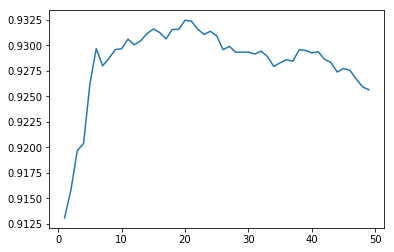

In [157]:
#improve leaf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
leaves = np.arange(1, 50)
res = []
for leaf in leaves:
    clf = DecisionTreeClassifier(criterion='entropy', min_samples_leaf = leaf,max_depth = 15)
    clf = clf.fit(X_train, Y_train)
    dt_preds = clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(Y_test, dt_preds)
    roc_auc = auc(fpr, tpr)
    res.append(auc(fpr, tpr))    
plt.plot(leaves,res)
plt.show()

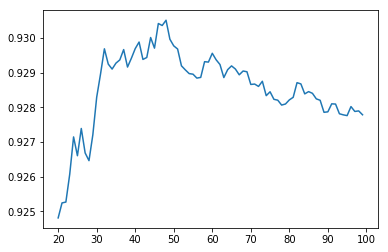

In [161]:
#improve  split 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
splits = np.arange(20, 100)
res = []
for split in splits:
    clf = DecisionTreeClassifier(criterion='entropy', min_samples_split = split,max_depth = 15)
    clf = clf.fit(X_train, Y_train)
    dt_preds = clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(Y_test, dt_preds)
    roc_auc = auc(fpr, tpr)
    res.append(auc(fpr, tpr))    
plt.plot(splits,res)
plt.show()

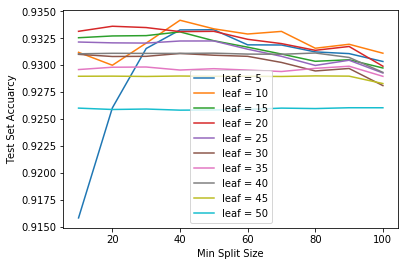

In [163]:
import matplotlib.pyplot as plt
%matplotlib inline
# Code here
min_samples_split_values = (10,20,30,40,50,60,70,80,90,100)
min_samples_leaf_values = (5,10,15,20,25,30,35,40,45,50)

fig = plt.figure()
ax=fig.add_subplot(111)
max_ac = 0
best_leaf = 1
best_split = 1
for leaf in min_samples_leaf_values:
    x_ls = []
    y_val = []
    for split in min_samples_split_values:
        fdt = DecisionTreeClassifier(criterion='entropy',min_samples_split = split,min_samples_leaf = leaf)
        fdt = fdt.fit(X_train,Y_train)
        x_ls.append(split)
        
        dt_preds = fdt.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(Y_test, dt_preds)
        ac = auc(fpr, tpr)
        y_val.append(ac)
        if(max_ac < ac):
            max_ac = ac
            best_leaf = leaf
            best_split = split
    plt.plot(x_ls,y_val,label='leaf = {}'.format(leaf))
plt.legend() 
ax.set_xlabel('Min Split Size')
ax.set_ylabel('Test Set Accuarcy')
plt.show()

In [164]:
max_ac,best_leaf,best_split

(0.93417125888584096, 10, 40)